# Notebook for Development

This notebook replicates what was alrady done in [the previous example](https://github.com/WatChMaL/ExampleNotebooks/blob/master/HKML%20CNN%20Image%20Classification.ipynb) but using functions in the `classification` module. There is no new ML example here. The purpose of this notebook is to make the whole thing short and concise, so that you can use this as a testbed to develop different networks more easily.

In [1]:
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np
%matplotlib inline

## Defining a network
Let us define the same network similar to how we did in the [the previous example](https://github.com/WatChMaL/ExampleNotebooks/blob/master/HKML%20CNN%20Image%20Classification.ipynb).

In [2]:
class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU()
        )
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))

## Preparing a _blob_

In [3]:
class BLOB:
    pass
blob=BLOB()
blob.net       = CNN(3).cuda() # construct Lenet for 3 class classification, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters(),weight_decay=0.001) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

# Create data loader
from iotools import loader_factory
DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']
# for train
blob.train_loader=loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)
# for validation
blob.test_loader=loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.2, use_fraction=0.1)

# Create & attach data recording utility (into csv file)
from utils import CSVData
blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')

## Running a train loop 

In [4]:
from classification import train_loop
train_loop(blob,10.0)

Epoch 0 Starting @ 2019-04-16 18:36:36


Epoch 1 Starting @ 2019-04-16 18:37:45


Epoch 2 Starting @ 2019-04-16 18:38:53


Epoch 3 Starting @ 2019-04-16 18:40:03


Epoch 4 Starting @ 2019-04-16 18:41:12


Epoch 5 Starting @ 2019-04-16 18:42:20


Epoch 6 Starting @ 2019-04-16 18:43:30


Epoch 7 Starting @ 2019-04-16 18:44:38


Epoch 8 Starting @ 2019-04-16 18:45:48


Epoch 9 Starting @ 2019-04-16 18:46:56


## Inspecting the training process

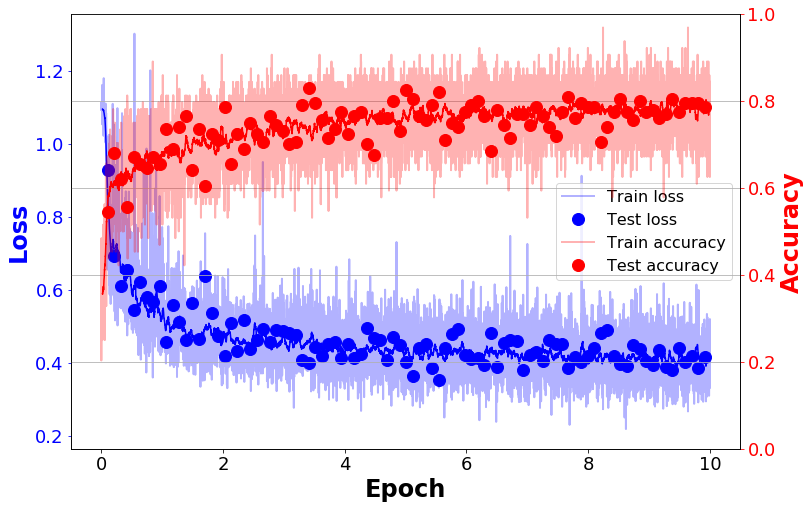

In [5]:
from classification import plot_log
plot_log(blob.train_log.name,blob.test_log.name)

## Performance Analysis

In [6]:
from classification import inference
accuracy,label,prediction = inference(blob,blob.test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())

Accuracy mean 0.76839995 std 0.027094403


Plot the confusion matrix

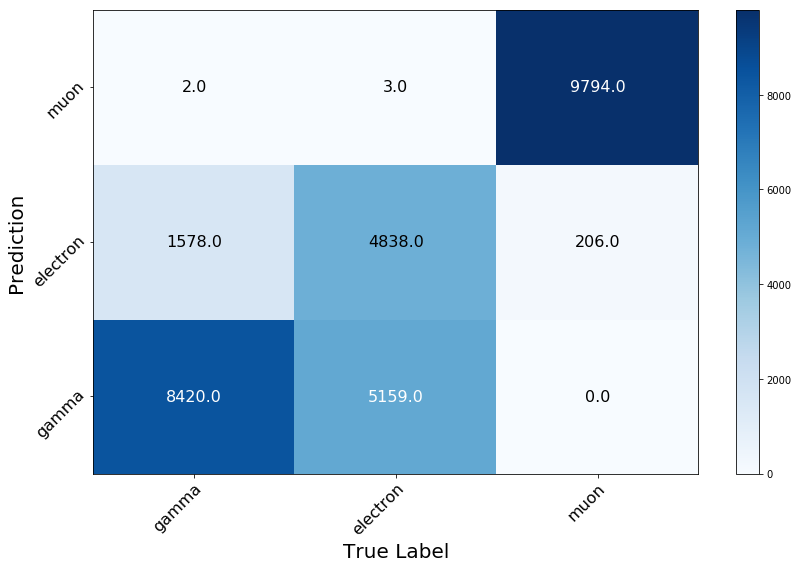

In [7]:
from utils import plot_confusion_matrix
plot_confusion_matrix(label,prediction,['gamma','electron','muon'])